In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
imge_size=256
btch_size=32

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
        "PlantVillage",
         shuffle=True,
         image_size=(imge_size,imge_size),
         batch_size=btch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
channels=3
n_classes=len(class_names)
n_classes

3

In [6]:
for image_batch,label_batch in dataset.take(2):
    print(image_batch.shape)
    print(label_batch.numpy())
#take is used to sample images from datset, here we have 2152/32 number of batches 
#and we are selecting first two batches of size 32 here by take
#256 is width, 256 is height and 3 are channels, 32 is size of batch

(32, 256, 256, 3)
[2 1 1 0 0 0 1 0 0 0 1 1 2 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0]
(32, 256, 256, 3)
[0 2 1 1 2 1 0 1 0 2 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0]


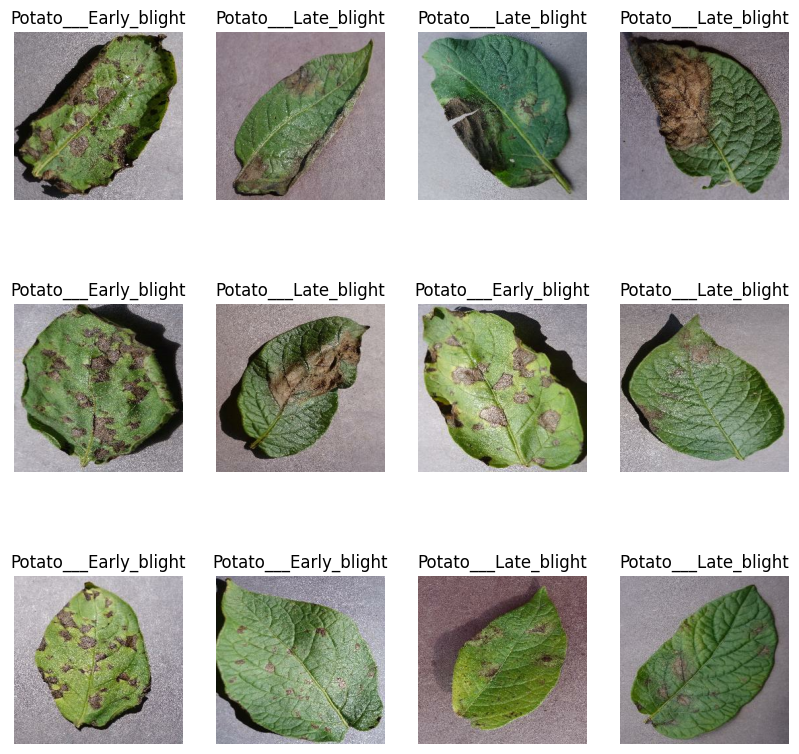

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(2):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
        #print(label_batch.numpy())

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
tes_ds=dataset.skip(54)
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds=tes_ds.take(6)
test_ds=tes_ds.skip(6)

In [12]:
def get_dataset_paritition_tf(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(dataset)
    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=dataset.take(train_size)
    val_ds=dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
    
    

In [13]:
train_ds,val_ds,test_ds=get_dataset_paritition_tf(dataset)
len(train_ds)

54

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imge_size,imge_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [17]:
input_shape=(btch_size,imge_size,imge_size,channels)
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
print(tf.version)

<module 'tensorflow._api.v2.version' from 'C:\\Users\\dell\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


In [20]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']       
             )

In [21]:
epoch=20
history=model.fit(train_ds,
         epochs=epoch,
          batch_size=btch_size,
          verbose=1,
          validation_data=val_ds
         )

Epoch 1/20
54/54 [==============================] - 118s 2s/step - loss: 0.9357 - accuracy: 0.4676 - val_loss: 0.9211 - val_accuracy: 0.4740
Epoch 2/20
54/54 [==============================] - 108s 2s/step - loss: 0.7386 - accuracy: 0.6441 - val_loss: 0.5089 - val_accuracy: 0.7656
Epoch 3/20
54/54 [==============================] - 115s 2s/step - loss: 0.4818 - accuracy: 0.7824 - val_loss: 0.3554 - val_accuracy: 0.8438
Epoch 4/20
54/54 [==============================] - 107s 2s/step - loss: 0.3060 - accuracy: 0.8733 - val_loss: 0.2520 - val_accuracy: 0.8906
Epoch 5/20
54/54 [==============================] - 105s 2s/step - loss: 0.2746 - accuracy: 0.8791 - val_loss: 0.4197 - val_accuracy: 0.8490
Epoch 6/20
54/54 [==============================] - 121s 2s/step - loss: 0.2332 - accuracy: 0.9039 - val_loss: 0.1651 - val_accuracy: 0.9271
Epoch 7/20
54/54 [==============================] - 118s 2s/step - loss: 0.2343 - accuracy: 0.9080 - val_loss: 0.1983 - val_accuracy: 0.9479
Epoch 8/20
54

In [22]:
model.evaluate(test_ds)

8/8 [==============================] - 5s 390ms/step - loss: 0.0927 - accuracy: 0.9688


[0.09267324209213257, 0.96875]

In [23]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

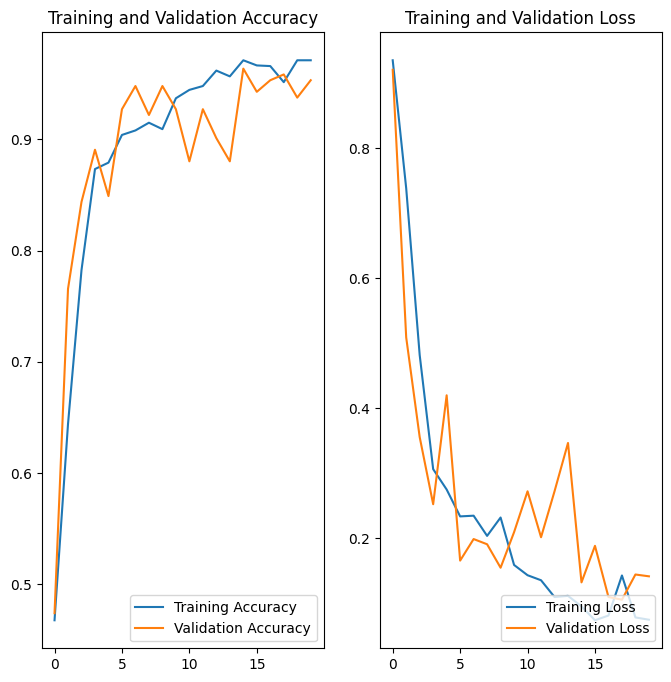

In [26]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epoch),acc,label='Training Accuracy')
plt.plot(range(epoch),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epoch),loss,label='Training Loss')
plt.plot(range(epoch),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')


first image to predict
first image's actual label: Potato___Late_blight
predicted label:  Potato___Late_blight


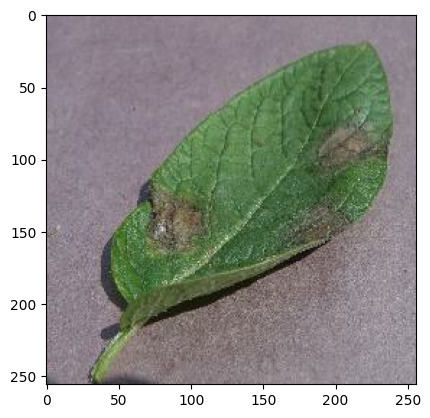

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    batch_pred= model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_pred[0])])

def

In [28]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

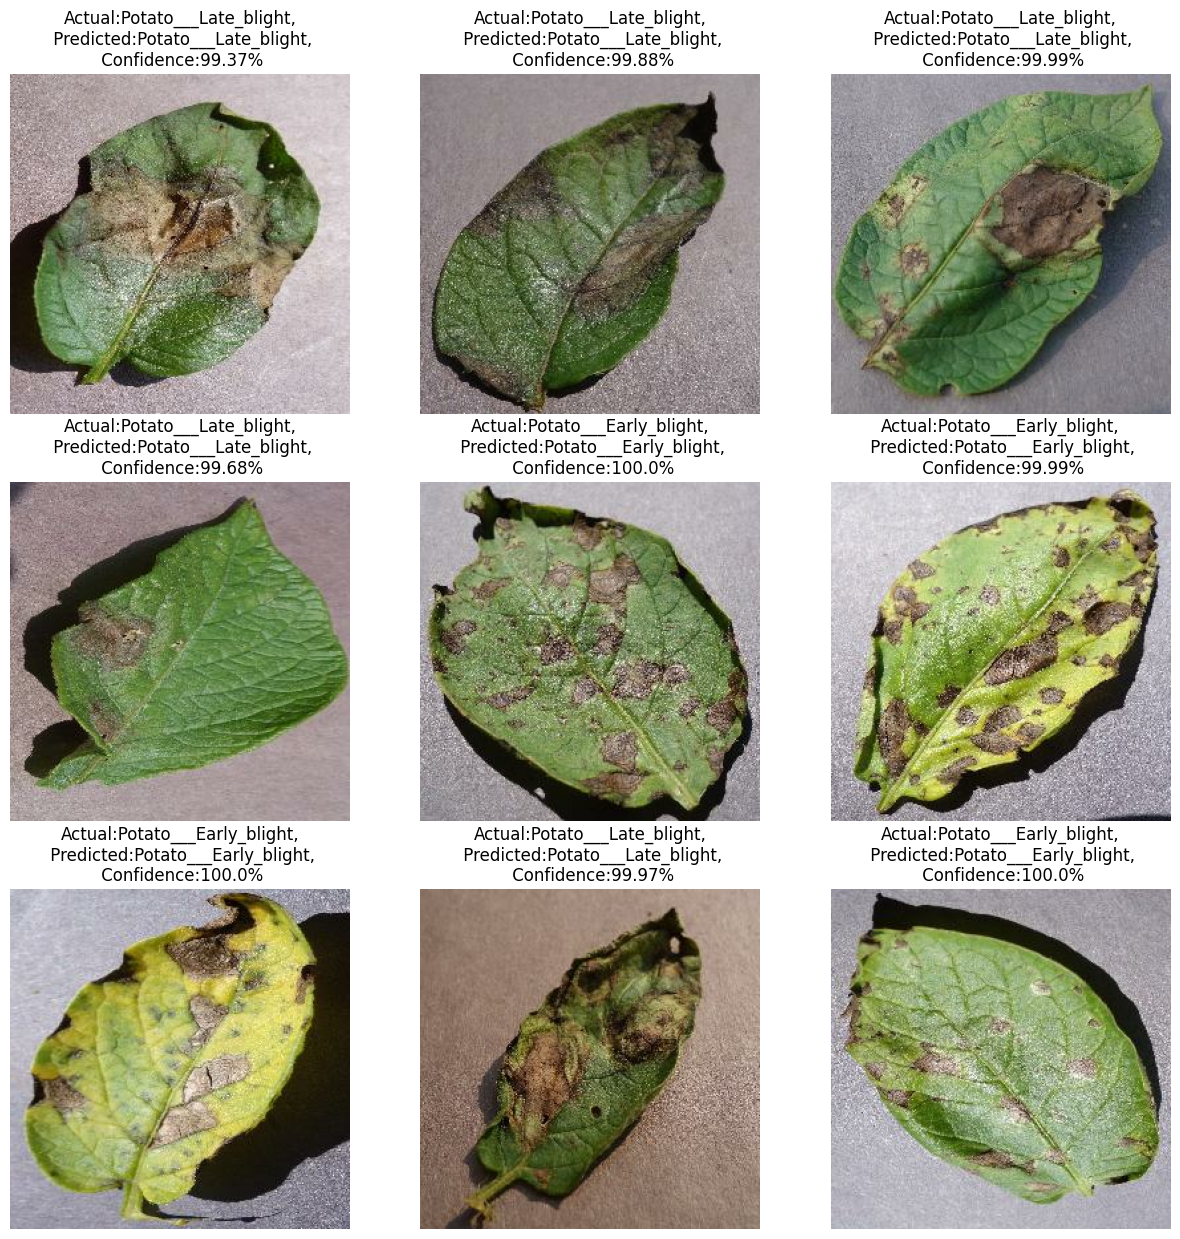

In [31]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=predict(model,images[i])   
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%")
        plt.axis("off")
        

In [32]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [33]:
import os
os.listdir("../models")

['1']

In [34]:
[ int(i) for i in os.listdir("../models")]

[1]